In [19]:
import numpy as np
import nibabel.cifti2 as ci
from itertools import product
from joblib import Parallel, delayed
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from graspy.plot import heatmap
%matplotlib inline

from hyppo.time_series import MGCX

## Look At It

In [5]:
# Load image - individual 100307.
img = ci.load("fmri_data/rfMRI_REST1_LR_Atlas_hp2000_clean_filt_sm6.HCPMMP.ptseries.nii")
fmri_data = np.array(img.get_fdata())

In [6]:
# Visualize data, i.e. inspect the first 60 timesteps of each parcel.

# Generate heatmap.
timesteps = 60
displayed_data = np.transpose(fmri_data[range(timesteps),:])
plt.subplots(figsize=(15,10))
ax = sns.heatmap(displayed_data, yticklabels=False)

# Plot parameters.
plt.title('Resting fMRI Signal by Parcel - Individual 100307 LR', fontsize = 20)
plt.ylabel('Parcel', fontsize = 15)
plt.xlabel('Timestep', fontsize = 15)
plt.show()

## Set Up Hyperparameters

In [7]:
# From Ting: Regions-of-Interest (ROIs)
roi_keys = np.array([1, 23, 18, 53, 24, 96, 117, 50, 143, 109, 148, 60, 38, 135, 93, 83, 149, 150, 65, 161, 132, 71]) - 1
roi_labels = np.array([
    "Visual",
    "Visual",
    "Visual",
    "SM",
    "SM",
    "dAtt",
    "dAtt",
    "dAtt",
    "dAtt",
    "vAtt",
    "vAtt",
    "vAtt",
    "vAtt",
    "Limbic",
    "Limbic",
    "FP",
    "FP",
    "DMN",
    "DMN",
    "DMN",
    "DMN",
    "DMN",
])

roi_data = fmri_data[0:300, roi_keys]
num_roi = len(roi_keys)

In [8]:
# Hyperparameters
max_lag = 1 # number of lags to check in the past
reps = 1000 # number of bootstrap replicates
workers = 1 # number of workers in internal MGC parallelization

In [9]:
# Subsample to test experiment.
# pairs = list(product(range(num_roi), repeat = 2)) # Fake param for testing.
pairs = list(product(range(num_roi), repeat = 2))

## Run Experiment

In [ ]:
mgcx = MGCX(max_lag = max_lag)

def worker(i, j):
    X = roi_data[:, i]
    Y = roi_data[:, j]
    
    stat, pval, mgcx_dict = mgcx.test(X, Y, reps = reps, workers = workers)
    opt_lag = mgcx_dict['opt_lag']
    opt_scale_x, opt_scale_y = mgcx_dict['opt_scale']
    
    return stat, pval, opt_lag, opt_scale_x, opt_scale_y

output = np.array(Parallel(n_jobs=-2)(delayed(worker)(i, j) for i, j in pairs))
pickle.dump(output, open('fmri_data/mgcx_fmri_output.pkl', 'wb'))

In [10]:
# Load results into num_roi-by-num_roi matrices.
results = pickle.load(open('fmri_data/mgcx_fmri_output.pkl', 'rb'))
test_outputs = ['stat', 'pval', 'opt_lag', 'opt_scale_x', 'opt_scale_y']

matrices = np.zeros((len(test_outputs), num_roi, num_roi))
for p, pair in enumerate(pairs):
    i, j = pair
    for t in range(len(test_outputs)):
        matrices[t, i, j] = results[p, t]
        
for t, test_output in enumerate(test_outputs):
    pickle.dump(matrices[t], open('fmri_data/%s_matrix.pkl' % test_output, 'wb'))

## Visualize Matrices

In [11]:
def plot_heatmap(matrix, labels, title, filename):
#     sns.set()
    cmap = mpl.cm.get_cmap('Purples')
    cc = np.linspace(0, 1, 256)
    cmap = mpl.colors.ListedColormap(cmap(cc))

    heatmap_kws = dict(
        cbar=False,
        font_scale=1.4,
        inner_hier_labels=labels,
        hier_label_fontsize=20,
        cmap=cmap,
        center=None,
    )
    side_label_kws = dict(labelpad=45, fontsize=24)

    fig, ax = plt.subplots(1, 1, figsize=(20, 16))

    # Plot heatmap via graspy.
    heatmap(matrix, ax=ax, **heatmap_kws)
    ax.set_title(title, pad = 100, fontdict = {'fontsize' : 23})
    
    # Create ticks.
    num_ticks = 8
    top_val = np.max(matrix)
    ticks = [i * np.max(matrix) / num_ticks for i in range(num_ticks+1)]
    yticks = [('%.2f' % np.round(10 ** -p, 2)) for p in ticks]

    # Add colorbar.
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(matrix)
    cbar = fig.colorbar(sm, ax=ax, fraction=0.0475, pad=-0.1, ticks=ticks)
    cbar.ax.set_yticklabels(yticks)
    cbar.ax.tick_params(labelsize=25)

    plt.savefig(
        "%s.pdf" % filename,
        facecolor="w",
        format="pdf",
        bbox_inches="tight",
    )

    plt.tight_layout()
    plt.show()

### p-value Matrix

In [13]:
# Apply negative log10 transform.
# matrix = pickle.load(open('fmri_data/pval_matrix.pkl', 'rb'))
# matrix = -np.log10(matrix)
# pickle.dump(matrix, open('fmri_data/nl10_pval_matrix.pkl', 'wb'))

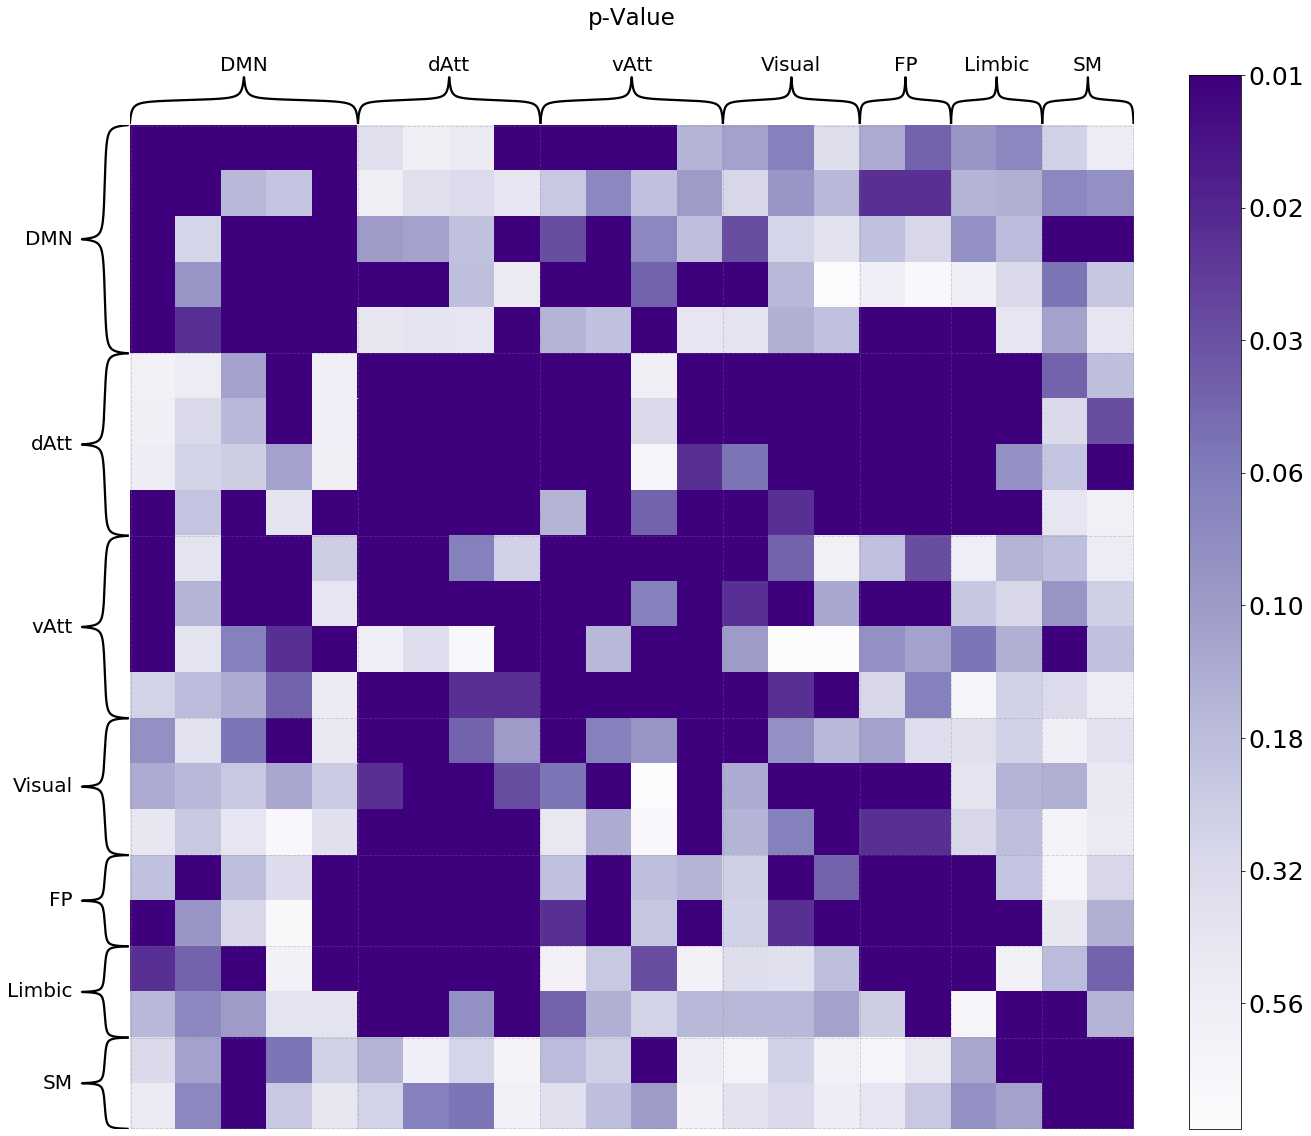

In [20]:
matrix = pickle.load(open('fmri_data/nl10_pval_matrix.pkl', 'rb'))
plot_heatmap(matrix, roi_labels, 'p-Value', 'pval')